# start

> ## version 7 model params:
> > - taking only labled data for training:
> > - try training with Adam,AdamW [12 epochs]
> > - params: resnet50,90/10,e12,bs8,SGD,conf:0.25
> > - img_size = 480p[852x480] previously it was 720p[1280x720]

|version|training| LB |
|-------|--------|----|
|v7|FasterRCNN:resnet50,90/10,e12,bs8,SGD,cnf0.15,i480,w/o aug| 0.291 LB |
|v1|FasterRCNN:resnet50,90/10,e12,bs8,SGD,cnf0.15,i480,geo aug| ? |

### Geo Aug tried: 
- A.Flip(0.4),
- A.HorizontalFlip(0.6)
- A.VerticalFlip(0.3),
- A.Cutout(num_holes=25, max_h_size=6, max_w_size=6, fill_value=0, p=0.5),


# references
- https://www.kaggle.com/c/global-wheat-detection/code?competitionId=19989&searchQuery=faster+RCNN
- https://www.kaggle.com/nvnnghia/awesome-augmentation/notebook
- https://www.kaggle.com/dhiiyaur/fasterrcnn-eda-augmentation-compare-models
- https://www.kaggle.com/aryaprince/getting-started-with-object-detection-with-pytorch
- https://www.kaggle.com/sadmanaraf/wheat-detection-using-faster-rcnn-train
- https://www.kaggle.com/arunmohan003/fasterrcnn-using-pytorch-baseline
- https://www.kaggle.com/arunmohan003/fasterrcnn-using-pytorch-baseline
- https://www.kaggle.com/yashchoudhary/gwd-fasterrcnn-with-augmentation-train-inference
- https://www.kaggle.com/ChristianDenich/end2end-object-detection-with-fasterrcnn#Augmentations
- https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
- https://www.google.com/search?q=why+some+rotational+augmeantations+from+albumentations+gives+empty+bounding+boxes+for+fasterRCNN+training+torchvision&oq=why+some+rotational+augmeantations+from+albumentations+gives+empty+bounding+boxes+for+fasterRCNN+training+torchvision&aqs=chrome..69i57.83035j0j1&sourceid=chrome&ie=UTF-8
- https://blog.paperspace.com/data-augmentation-for-object-detection-building-input-pipelines/
- https://www.kaggle.com/yerramvarun/fine-tuning-faster-rcnn-using-pytorch/notebook

In [1]:
# %cd test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
import shutil
import torch.nn as nn
from skimage import io
import torchvision
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from albumentations.pytorch import ToTensorV2
from torchvision import utils
import albumentations as A
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)

from torchvision import transforms
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = DEVICE
BASE_DIR = "../input/tensorflow-great-barrier-reef/train_images/"

num_epochs = 12
width = 852
height = 480

In [2]:
df = pd.read_csv("../input/reef-cv-strategy-subsequences-dataframes/train-validation-split/train-0.1.csv")

# Turn annotations from strings into lists of dictionaries
df['annotations'] = df['annotations'].apply(eval)

# Create the image path for the row
df['image_path'] = "video_" + df['video_id'].astype(str) + "/" + df['video_frame'].astype(str) + ".jpg"

df_train, df_val = df[df['is_train']], df[~df['is_train']]

df_train = df_train[df_train.annotations.str.len() > 0 ].reset_index(drop=True)
df_val = df_val[df_val.annotations.str.len() > 0 ].reset_index(drop=True)

df_train.shape[0], df_val.shape[0]

(4396, 523)

In [3]:
"""For normal splitting"""

# train_df = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv")
# # train_df['annotations'].iloc[3]
# train_df['annotations'] = train_df['annotations'].apply(eval)
# func = lambda x: "video_"+x.split("-")[0]+"/"+x.split("-")[1]+".jpg"
# # vid_func = lambda x: "video_"+x.split("-")[0]

# train_df["img_path"] = train_df["image_id"].apply(func)
# # train_df["vid_path"] = train_df["image_id"].apply(vid_func)
# # train_df.head()
# train_df["no_of_bbox"] = train_df["annotations"].apply(lambda x: len(x))
# train_df = train_df[train_df["no_of_bbox"]>0].reset_index(drop=True)
# train_df.head()


# train_df[train_df["no_of_bbox"]==1]


# boxes = pd.DataFrame(train_df['annotations'].iloc[19], columns=['x', 'y', 'width', 'height']).astype(float).values
# boxes

# boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
# boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
# # boxes
# # --> array([[520., 151., 598., 213.],
# #        [598., 204., 656., 236.]])

'For normal splitting'

# dataloader

In [4]:
class ReefDataset:
    
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    def can_augment(self, boxes):
        """ Check if bounding boxes are OK to augment
        
        
        For example: image_id 1-490 has a bounding box that is partially outside of the image
        It breaks albumentation
        Here we check the margins are within the image to make sure the augmentation can be applied
        """
        
        box_outside_image = ((boxes[:, 0] < 0).any() or (boxes[:, 1] < 0).any() 
                             or (boxes[:, 2] > 1280).any() or (boxes[:, 3] > 720).any())
        return not box_outside_image
        
    def get_boxes(self, row):
        """Returns the bboxes for a given row as a 3D matrix with format [x_min, y_min, x_max, y_max]"""
        
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(float).values
        
        # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
        boxes[:, 2] = np.clip(boxes[:, 0] + boxes[:, 2],0,1280)
        boxes[:, 3] = np.clip(boxes[:, 1] + boxes[:, 3],0,720)
        return boxes
    
    def get_image(self, row):
        """Gets the image for a given row"""
        
        image = cv2.imread(f'{BASE_DIR}/{row["image_path"]}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        return image
    
    def __getitem__(self, i):

        row = self.df.iloc[i]
        image = self.get_image(row)
        boxes = self.get_boxes(row)
        
        n_boxes = boxes.shape[0]
        
        # Calculate the area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'area': torch.as_tensor(area, dtype=torch.float32),
            
            'image_id': torch.tensor([i]),
            
            # There is only one class
            'labels': torch.ones((n_boxes,), dtype=torch.int64), #unchanged
            
            # Suppose all instances are not crowd
            'iscrowd': torch.zeros((n_boxes,), dtype=torch.int64) #unchanged   
        }
        
#         if self.transforms is not None:
#             image, target = self.transforms(image, target)
#         return image, target

        if self.transforms and self.can_augment(boxes):
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
#             target['boxes'] = torch.as_tensor(sample['bboxes'])
#             if len(tensor.size()) != 0:
#                 target['boxes'] = target['boxes'].int()
#                 target['boxes'] = target['boxes'].to(torch.float32)
#                 print(f"{torch.tensor([i])} : {target['boxes'].shape}")
#                 print(f"{torch.tensor([i])} : {target['boxes']}")
#                 print("#"*80)
#                 return image, target
#             else:
#                 continue
                
#             print(*sample['bboxes'][0])
            if n_boxes > 0:
#                 print(torch.tensor(sample['bboxes']))
                target['boxes'] = torch.as_tensor(sample['bboxes']).int()
                target['boxes'] = target['boxes'].to(torch.float32)
#                 print(f"{torch.tensor([i])} : {target['boxes'].shape}")
#                 print(f"{torch.tensor([i])} : {target['boxes']}")
#                 print("#"*80)

        else:
            image = ToTensorV2(p=1.0)(image=image)['image']
            
#         if target['boxes'].shape != (0):
        return image, target

    def __len__(self):
        return len(self.df)

In [5]:
# def get_train_transform():
#     return transforms.Compose([
#          transforms.CenterCrop(10),
#          transforms.PILToTensor(),
#          transforms.ConvertImageDtype(torch.float),
#      ])

# import torchvision.transforms as T

# def get_transform(train):
#     transforms = []
#     transforms.append(T.ToTensor())
#     if train:
#         transforms.append([T.RandomHorizontalFlip(0.5),
#                          T.CenterCrop(10)]
#                          )
#     return T.Compose(transforms)

def get_train_transform():
#     https://tugot17.github.io/data-science-blog/albumentations/data-augmentation/tutorial/2020/09/17/Spatial-level-transforms-using-albumentations-package.html#OpticalDistortion
    # IAAAffine properties [creates problem]
#     scale=0.1
#     translate_percent=10
#     translate_px=None
#     rotate=0
#     shear=0.5
#     order=1
#     cval=0
#     mode='reflect'
    
    # rotate properties [Failed]
#     limit=15
#     interpolation=1
#     border_mode=4
#     value=None
#     mask_value=None
    # OpticalDistortion [failed]
#     distort_limit=1.5
#     shift_limit=0.4
#     interpolation=1
#     border_mode=4
#     value=None
#     mask_value=None
    
    return A.Compose([
        A.Resize(height=height, width=width, p=1.0),
        A.Flip(0.4),
        A.HorizontalFlip(0.6), # Same with transforms.RandomHorizontalFlip()
#         A.SafeRotate(limit = 15, p = 0.5), 
        A.VerticalFlip(0.3), 
#         A.RandomRotate90(p = 0.5),
#         A.OneOf([
#             A.RGBShift(), 
#             A.HueSaturationValue()
#         ]),
#         A.OpticalDistortion(distort_limit, shift_limit, interpolation, border_mode, value, mask_value, p=0.5),

#         A.HueSaturationValue(),
#         A.IAAAffine(scale, translate_percent, translate_px, rotate, shear, order, cval, mode, p=0.4),
#         A.Rotate(limit, interpolation, border_mode, value, mask_value, p=0.5),
        A.Cutout(num_holes=25, max_h_size=6, max_w_size=6, fill_value=0, p=0.5),
#         A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Mean of the image: [0.222, 0.577, 0.658]
# Std of the image: [0.175, 0.176, 0.162]
# def get_train_transform():
#     return A.Compose([
#         A.RandomSizedCrop(min_max_height=(500, 500), height=1024, width=1024, p=0.5),
#         A.OneOf([
#             A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
#                                  val_shift_limit=0.2, p=0.9),
#             A.RandomBrightnessContrast(brightness_limit=0.2, 
#                                        contrast_limit=0.2, p=0.9),
#         ],p=0.9),
#         A.ToGray(p=0.01),
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
#         A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
#         ToTensorV2(p=1.0)
#     ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [6]:
# df_train = train_df.iloc[0: 1427]
# df_val = train_df.iloc[1428:1918]

ds_train = ReefDataset(df_train,get_train_transform())
ds_val = ReefDataset(df_val,get_valid_transform())

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [7]:
image, targets = ds_train[45]
# image = image.permute(2,1,0).numpy()
# plt.imshow(image)
# img = image.permute(1,2,0).cpu().numpy()
# # plt.imshow(image.numpy().reshape((720, 1280,3)))
# print(img.shape)
# plt.figure(figsize=(16,18))


# plt.imshow(img)

"""
boxes:  [[344. 105.  66.  73.]]
[66.]
"""

'\nboxes:  [[344. 105.  66.  73.]]\n[66.]\n'

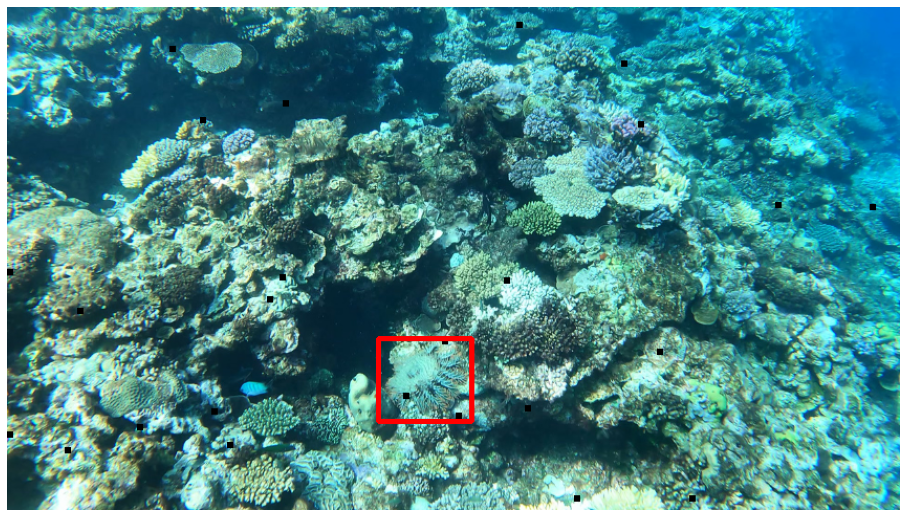

In [8]:
boxes = targets['boxes'].cpu().numpy().astype(np.int32)

img2 = image.permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 18))

for box in boxes:
    cv2.rectangle(img2,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
# fig.figure(figsize=(16,18))
ax.imshow(img2);

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

dl_train = DataLoader(ds_train, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)
dl_val = DataLoader(ds_val, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [10]:
# for img,trg in dl_train:
#     print(trg[0].shape)
#     break

# model:

In [11]:
def get_model():
    # load a model; pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    num_classes = 2  # 1 class (starfish) + background

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    model.to(device)
    return model

model = get_model()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

# F2 cal:

In [12]:
from typing import List

import numpy as np
import torch
from torchvision.ops import box_iou


def calculate_score(
    preds: List[torch.Tensor],
    gts: List[torch.Tensor],
    iou_th: float
) -> float:
    num_tp = 0
    num_fp = 0
    num_fn = 0
    for p, gt in zip(preds, gts):
        if len(p) and len(gt):
            iou_matrix = box_iou(p, gt)
            tp = len(torch.where(iou_matrix.max(0)[0] >= iou_th)[0])
            fp = len(p) - tp
            fn = len(torch.where(iou_matrix.max(0)[0] < iou_th)[0])
            num_tp += tp
            num_fp += fp
            num_fn += fn
        elif len(p) == 0 and len(gt):
            num_fn += len(gt)
        elif len(p) and len(gt) == 0:
            num_fp += len(p)
    if (5 * num_tp + 4 * num_fn + num_fp )!=0:
        score = 5 * num_tp / (5 * num_tp + 4 * num_fn + num_fp )
    else:
        score = np.nan
    if (num_tp+num_fn) != 0:
        recall = num_tp/ (num_tp+num_fn)
    else:
        recall=np.nan
    if (num_tp+num_fp)!=0:
        precission = num_tp/ (num_tp+num_fp)
    else:
        precission=np.nan


    return score, precission, recall




# Training:

In [13]:


# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.0025, momentum=0.9, weight_decay=0.0005)
# # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = None
# confthre = 0.25
# n_batches, n_batches_val = len(dl_train), len(dl_val)
# validation_losses = []
# train_need = True

# for epoch in range(NUM_EPOCHS):
#     time_start = time.time()
#     loss_accum = 0
    
#     for batch_idx, (images, targets) in enumerate(dl_train, 1):
#         model = model.train()
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         # Predict
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         loss_value = losses.item()

#         loss_accum += loss_value

#         # Back-prop
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

    
#     # update the learning rate
#     if lr_scheduler is not None:
#         lr_scheduler.step()
        
#     # Validation 
#     val_loss_accum = 0
    
    
#     iou_ths = np.arange(0.3, 0.85, 0.05)
    
#     with torch.no_grad():
#         for batch_idx, (images, targets) in enumerate(dl_val, 1):
#             images = list(image.to(device) for image in images)
#             targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
#             val_loss_dict = model(images, targets)
# #             print(val_loss_dict)
#             val_batch_loss = sum(loss for loss in val_loss_dict.values())
#             val_loss_accum += val_batch_loss.item()
            
            
#     val_f2_scores = []
    
#     for batch_idx, (images, targets) in enumerate(dl_val):


#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]     
#         model = model.eval()
#         preds = model(images)
            
#         for i in range(len(images)):
            
# #             print(preds[i]['boxes'].dtype)
# #             print(preds[i]['scores'].dtype)
# #             print(preds[i]['labels'].dtype)

#             preds[i]['boxes']=preds[i]['boxes'][preds[i]['scores']>confthre]
#             preds[i]['boxes']=preds[i]['boxes'].int()
#             score = [calculate_score(preds[i]['boxes'].unsqueeze(0), targets[i]['boxes'].unsqueeze(0), iou_th)[0] for iou_th in iou_ths]
#             val_f2_scores.append(np.nanmean(score))
    
    
#     # Logging
#     val_loss = val_loss_accum / n_batches_val
#     train_loss = loss_accum / n_batches
#     validation_losses.append(val_loss)
    
#     # Save model
#     chk_name = f'fasterrcnn_resnet50_fpn-e{epoch}.pth'
#     torch.save(model.state_dict(), chk_name)
    
    
#     elapsed = time.time() - time_start
    
#     print(f"[Epoch {epoch+1:2d} / {NUM_EPOCHS:2d}] Train loss: {train_loss:.3f}. Val loss: {val_loss:.3f} --> {chk_name} val F2: {np.nanmean(val_f2_scores):.3f} | time: [{elapsed:.0f} secs] ")   

# training 1:

In [14]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [15]:
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.0025, momentum=0.9, weight_decay=0.0005)
# # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = None
# itr = 1
# confthre = 0.15
# n_batches, n_batches_val = len(dl_train), len(dl_val)
# validation_losses = []
# NUM_EPOCHS = 2

# for epoch in range(NUM_EPOCHS):
#     time_start = time.time()
#     loss_accum = 0
    
#     for batch_idx, (images, targets) in enumerate(dl_train, 1):
        
# #         images = list(image.to(DEVICE) for image in images)
# #         targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
#         images = list(image.float().to(DEVICE) for image in images)
#         targets = [{k: v.to(torch.float32).to(DEVICE) if "box" in k else v.to(DEVICE) for k, v in t.items()} for t in targets]

#         # Predict
#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())
#         loss_value = losses.item()

#         loss_accum += loss_value

#         # Back-prop
#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

        
#         if itr % 50 == 0:
#             print(f"Iteration #{itr} loss: {loss_value}")

#         itr += 1
    
#     # update the learning rate
#     if lr_scheduler is not None:
#         lr_scheduler.step()

# #     # Validation 
# #     val_loss_accum = 0
        
# #     with torch.no_grad():
# #         for batch_idx, (images, targets) in enumerate(dl_val, 1):
# #             images = list(image.to(DEVICE) for image in images)
# #             targets = [{k: v.to(torch.float32).to(DEVICE) if "box" in k else v.to(DEVICE) for k, v in t.items()} for t in targets]

            
# #             val_loss_dict = model(images, targets)
# #             val_batch_loss = sum(loss for loss in val_loss_dict.values())
# #             val_loss_accum += val_batch_loss.item()
    
    
    
#     val_f2_scores = []
#     iou_ths = np.arange(0.3, 0.85, 0.05)
#     for batch_idx, (images, targets) in enumerate(dl_val):
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]     
#         model1 = model.eval()
#         preds = model1(images)
#         for i in range(len(images)):
#             preds[i]['boxes']=preds[i]['boxes'][preds[i]['scores']>confthre]
#             preds[i]['boxes']=preds[i]['boxes'].int()
#             score = [calculate_score(preds[i]['boxes'].unsqueeze(0), targets[i]['boxes'].unsqueeze(0), iou_th)[0] for iou_th in iou_ths]
#             val_f2_scores.append(np.nanmean(score))
    
    
#     # Logging
# #     val_loss = val_loss_accum / n_batches_val
#     train_loss = loss_accum / n_batches
# #     validation_losses.append(val_loss)
    
#     # Save model
#     chk_name = f'fasterrcnn_resnet50_fpn-e{epoch}.bin'
#     torch.save(model.state_dict(), chk_name)
    
    
#     elapsed = time.time() - time_start
#     # Val loss: {val_loss:.3f}
#     print(f"[Epoch {epoch+1:2d} / {NUM_EPOCHS:2d}] Train loss: {train_loss:.3f}. |  val F2: {np.nanmean(val_f2_scores):.3f} --> {chk_name}  [{elapsed:.0f} secs]") 

In [16]:
loss_hist = Averager()
itr = 1
num_epochs = 12
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = None
confthre = 0.15
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
n_batches, n_batches_val = len(dl_train), len(dl_val)


for epoch in range(num_epochs):
    print("#"*20 + f"   New epoch [{epoch+1}/{num_epochs}]  " + "#"*20) 
    print()
    loss_hist.reset()
    loss_accum = 0
    train_time_start = time.time()
    
    
    for batch_idx, (images, targets) in enumerate(dl_train, 1):
        model = model.train()
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        images = list(image.float().to(DEVICE) for image in images)
        targets = [{k: v.to(torch.float32).to(DEVICE) if "box" in k else v.to(DEVICE) for k, v in t.items()} for t in targets]
#         print(i["boxes"].shape for i in targets )
        # Predict
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_accum += loss_value

        # Back-prop
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
#     for images, targets, image_ids in train_data_loader:
        
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)

#         losses = sum(loss for loss in loss_dict.values())
#         loss_value = losses.item()

#         loss_hist.send(loss_value)

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value:.4f}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    
    
    
    val_f2_scores = []
    iou_ths = np.arange(0.3, 0.85, 0.05)

    for batch_idx, (images, targets) in enumerate(dl_val):


        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]     
        model1 = model.eval()
        preds = model1(images)
            
        for i in range(len(images)):
            
            preds[i]['boxes']=preds[i]['boxes'][preds[i]['scores']>confthre]
            preds[i]['boxes']=preds[i]['boxes'].int()
            score = [calculate_score(preds[i]['boxes'].unsqueeze(0), targets[i]['boxes'].unsqueeze(0), iou_th)[0] for iou_th in iou_ths]
            val_f2_scores.append(np.nanmean(score))
    
    train_loss = loss_accum / n_batches
    
    
    PATH = f'fasterrcnn_resnet50_fpn-e{epoch}.pt'
    torch.save(model.state_dict(), PATH)
    
    elapsed = time.time() - train_time_start
    
    
       
    print(f"Epoch [{epoch+1}/{num_epochs}] train loss: {train_loss:.3f}  |  saving file to: {PATH}  |  val F2: {np.nanmean(val_f2_scores):.3f} | time: [{elapsed:.0f} secs]") 
#     print("~"*80)
    print()

####################   New epoch [1/12]  ####################

Iteration #50 loss: 0.1040
Iteration #100 loss: 0.3742
Iteration #150 loss: 0.1497
Iteration #200 loss: 0.1384
Iteration #250 loss: 0.2677
Iteration #300 loss: 0.2141
Iteration #350 loss: 0.0866
Iteration #400 loss: 0.2614
Iteration #450 loss: 0.2663
Iteration #500 loss: 0.8711
Iteration #550 loss: 0.1421
Epoch [1/12] train loss: 0.259  |  saving file to: fasterrcnn_resnet50_fpn-e0.pt  |  val F2: 0.004 | time: [757 secs]

####################   New epoch [2/12]  ####################

Iteration #600 loss: 0.0813
Iteration #650 loss: 0.3037
Iteration #700 loss: 0.1067
Iteration #750 loss: 0.1364
Iteration #800 loss: 0.3405
Iteration #850 loss: 0.2171
Iteration #900 loss: 0.0917
Iteration #950 loss: 0.1754
Iteration #1000 loss: 0.3196
Iteration #1050 loss: 0.7151
Iteration #1100 loss: 0.1331
Epoch [2/12] train loss: 0.241  |  saving file to: fasterrcnn_resnet50_fpn-e1.pt  |  val F2: 0.140 | time: [751 secs]

##################

In [17]:
# # ValueError: Expected target boxes to be a tensorof shape [N, 4], got torch.Size([0]).
# for img,trg in dl_train:
#     if trg[0]["boxes"].shape == (0):
#         print("hi")
#         print(" length -----> ", trg[0]["boxes"].shape)
#     break

In [18]:
# print("#"*12 + "hi absdfobasodb")

In [19]:
loaded_model = get_model()
loaded_model.load_state_dict(torch.load( "./fasterrcnn_resnet50_fpn-e0.pt"))

<All keys matched successfully>

In [20]:
idx = 6

images, targets= next(iter(dl_val))
images = list(img.to(device) for img in images)
# print(images[0])
print(len(images))
targets = [{k: v.to(torch.float32).to(device) if "box" in k else v.to(device) for k, v in t.items()} for t in targets]
        
boxes = targets[idx]['boxes'].cpu().numpy().astype(np.int32)
sample = images[idx].to(device)
# sample = images[idx].permute(1,2,0).cpu().numpy()
# sample
# # boxes
loaded_model.eval()

outputs1 = loaded_model([sample])
# outputs = [{k: v.detach().cpu().numpy() if "box" in k else v.to(device) for k, v in t.items()} for t in outputs]

8


In [21]:
outputs1

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0', grad_fn=<IndexBackward>)}]

In [22]:
boxes

array([[656, 190, 684, 214]], dtype=int32)

In [23]:
# images, boxes = torch.rand(2, 3, 400, 400).to(device), torch.rand(2, 11, 4).to(device)
# boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
# labels = torch.randint(0, 2, (4, 11)).to(device)
# images = list(image for image in images)
# targets = []
# for i in range(len(images)):
#     d = {}
#     d['boxes'] = boxes[i]
#     d['labels'] = labels[i]
#     targets.append(d)

In [24]:
# #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
# model = model.to(DEVICE)
# model.eval()
# output = model(images)
# output